### Carregar bibliotecas

In [1]:
import pandas as pd
import glob
import joblib
import sklearn
from datetime import datetime

### Carregar dados de validação

In [2]:
dados_validacao = pd.read_csv('dados/validacao.csv', sep=';')

dados_validacao.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_Red,type_White
0,6.8,0.37,0.28,1.9,0.024,64.0,106.0,0.98993,3.45,0.60,12.6,8,0,1
1,5.0,0.17,0.56,1.5,0.026,24.0,115.0,0.99060,3.48,0.39,10.8,7,0,1
2,5.9,0.12,0.28,1.4,0.037,36.0,83.0,0.99074,3.33,0.42,10.9,7,0,1
3,6.0,0.20,0.26,6.8,0.049,22.0,93.0,0.99280,3.15,0.42,11.0,6,0,1
4,5.7,0.33,0.32,1.4,0.043,28.0,93.0,0.98970,3.31,0.50,12.3,6,0,1


In [3]:
dados_validacao.shape

(1292, 14)

### Separar dados em atributos (X) e classe (y)

In [4]:
X = dados_validacao.drop('quality', axis=1)
y = dados_validacao.quality

In [5]:
def log(mensagem):
    """
    Função para receber uma mensagem e exibir.
    Futuramente esta função pode receber a funcionalidade de salvar as mensagens de log em arquivo
    """
    print(str(datetime.now()) + ': ' + mensagem)

In [6]:
def tratarPredict(predict):
    """
    Função para tratar os valores preditos.
    É necessário tratar os valores preditos pelos seguintes motivos:
        - O atributo classe 'quality' é do tipo inteiro e deve conter valores entre 0 e 10
        - Uma técnica de regressão pode predizer valores que não são inteiros. Exemplo: 4.27
        - Uma técnica de regressão pode predizer valores abaixo de 0 (valores negativos) e valores acima de 10
        
    Tratamentos realizados:
        - Arredondar valor para número inteiro
        - Se o valor for menor que 0, atribuir o valor de 0
        - Se o valor for maior que 10, atribuir o valor de 10
    """
    
    predict = predict.round()
    predict = predict.astype('int')
    
    predict[predict < 0] = 0
    
    predict[predict > 10] = 10
    
    return predict
    

In [7]:
def salvarDesempenho(resultados):
    """
    Função que recebe um Pandas DataFrame por parâmetro, e salva os dados no arquivo CSV.
    Caso já exista um arquivo, os dados recebidos por parâmetro são adicionados no arquivo
    """
    
    nome_arquivo = 'resultados_validacao.csv'    
    
    try:
        csv_resultados = pd.read_csv(nome_arquivo, sep=';') # Abrir arquivo existente
        csv_resultados = pd.concat([csv_resultados, resultados]) # Adicionar dados recebidos por parâmetro ao conjunto de dados já existente
        csv_resultados.to_csv(nome_arquivo, sep=';', index=False) # Salvar os dados
    except FileNotFoundError: # Caso não exista o arquivo, será criado um novo com os dados recebido por parâmetro
        resultados.to_csv(nome_arquivo, sep=';', index=False)

In [8]:
def avaliarDesempenho(tecnica, y_true, y_pred):
    """
    Função que recebe o valor verdadeiro/real (y_true) e o valor predito (y_pred), 
    aplica os avaliadores de desempenho e retorna o resultado dos avaliadores de desempenho.
    Avaliadores de desempenho aplicados:
        - mean_absolute_error
        - mean_squared_error
        - mean_squared_log_error
        - median_absolute_error
    """
    
    resultados = {}
    resultados['tecnica'] = [tecnica]
    # Aplicando avaliadores de desempenho
    resultados['mean_absolute_error'] = [sklearn.metrics.mean_absolute_error(y_true, y_pred)]
    resultados['mean_squared_error'] = [sklearn.metrics.mean_squared_error(y_true, y_pred)]
    resultados['mean_squared_log_error'] = [sklearn.metrics.mean_squared_log_error(y_true, y_pred)]
    resultados['median_absolute_error'] = [sklearn.metrics.median_absolute_error(y_true, y_pred)]


    log('Técnica: {0} - mean_absolute_error: {1}, mean_squared_error: {2}, mean_squared_log_error: {3}, median_absolute_error: {4}'.format(
            tecnica, resultados['mean_absolute_error'], resultados['mean_squared_error'], resultados['mean_squared_log_error'], resultados['median_absolute_error']) )
    
    
    pd_resultados = pd.DataFrame(data=resultados)
    
    
    return pd_resultados    

In [9]:
def validacao(X_valid, y_valid):
    """
    Função responsável por ler todos os modelos presentes em uma pasta, e para cada modelo:
        - Carregar o modelo salvo
        - Realizar a predição com os dados de validação
        - Aplicar os avaliadores de desempenho
        - Salvar os resultados dos avaliadores de desempenho
    """
    
    modelos = glob.glob('modelos/*.pkl') # Listar o caminho de todos os modelos salvos na pasta
    
    for caminho_modelo in modelos: # Para cada modelo
        
        tecnica = caminho_modelo.split('_')[1].split('.')[0] # Coletando o nome da técnica
        identificador_aleatorio = caminho_modelo.split('\\')[1].split('_')[0] # Coletando o identificador aleatório do modelo salvo
        
        log('Técnica: {0}, identificar aleatório: {1}'.format(tecnica, identificador_aleatorio))
        
        modelo = joblib.load(caminho_modelo) # Carregando o modelo salvo
        
        y_pred = modelo.predict(X_valid) # Realizando a predição com os dados de validação
        
        y_pred = tratarPredict(y_pred) # Tratar os valores preditos
        
        desempenho_tecnica = avaliarDesempenho(tecnica=tecnica, y_true=y_valid, y_pred=y_pred) # Chamando a função que avalia o desempenho da técnica
        
        desempenho_tecnica['identificador_aleatorio'] = [identificador_aleatorio]
        desempenho_tecnica['tecnica'] = [tecnica]
        
        salvarDesempenho(desempenho_tecnica) # Salvando o desempenho da técnica
    

In [10]:
# Executando a função que valida todos os modelos salvos, utilizando os dados de validação
validacao(X, y)

2019-09-01 19:26:30.217018: Técnica: SGDRegressor, identificar aleatório: 1029309
2019-09-01 19:26:30.877952: Técnica: SGDRegressor - mean_absolute_error: [0.5735294117647058], mean_squared_error: [0.6787925696594427], mean_squared_log_error: [0.014679747334974078], median_absolute_error: [1.0]
2019-09-01 19:26:30.883948: Técnica: PassiveAggressiveRegressor, identificar aleatório: 1047690
2019-09-01 19:26:30.888944: Técnica: PassiveAggressiveRegressor - mean_absolute_error: [0.8831269349845201], mean_squared_error: [1.4140866873065014], mean_squared_log_error: [0.029958365678335323], median_absolute_error: [1.0]
2019-09-01 19:26:30.895940: Técnica: RadiusNeighborsRegressor, identificar aleatório: 1048406
2019-09-01 19:26:31.033855: Técnica: RadiusNeighborsRegressor - mean_absolute_error: [0.6323529411764706], mean_squared_error: [0.8397832817337462], mean_squared_log_error: [0.028173119961684288], median_absolute_error: [1.0]
2019-09-01 19:26:31.041850: Técnica: TheilSenRegressor, iden

### Lendo o arquivo com os resultados de validação

In [11]:
resultados_validacao = pd.read_csv('resultados_validacao.csv', sep=';')

resultados_validacao.head(10)

,tecnica,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,identificador_aleatorio
0,SGDRegressor,0.573529,0.678793,0.014680,1.0,1029309
1,PassiveAggressiveRegressor,0.883127,1.414087,0.029958,1.0,1047690
2,RadiusNeighborsRegressor,0.632353,0.839783,0.028173,1.0,1048406
3,TheilSenRegressor,0.550310,0.669505,0.014596,0.0,1064270
4,AdaBoostRegressor,0.500000,0.600619,0.013005,0.0,1071468
5,KNeighborsRegressor,0.479876,0.625387,0.013786,0.0,1108171
6,TheilSenRegressor,0.604489,1.290248,0.088702,0.0,1109023
7,KNeighborsRegressor,0.470588,0.578947,0.012805,0.0,112302
8,GradientBoostingRegressor,0.599845,0.740712,0.016185,1.0,1142980
9,ExtraTreeRegressor,0.584365,0.906347,0.020491,0.0,1154630


##### Identificando os 20 melhores desempenhos com base na métrica 'mean_squared_log_error'

In [12]:
resultados_validacao.sort_values('mean_squared_log_error', ascending=True).head(15)

,tecnica,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,identificador_aleatorio
266,ExtraTreesRegressor,0.343653,0.410217,0.009134,0.0,9887515
271,ExtraTreesRegressor,0.357585,0.417957,0.009231,0.0,9970987
200,BaggingRegressor,0.360681,0.422601,0.009235,0.0,7646377
250,ExtraTreesRegressor,0.358359,0.418731,0.009237,0.0,9341466
16,ExtraTreesRegressor,0.352167,0.420279,0.009264,0.0,1464304
181,ExtraTreesRegressor,0.367647,0.429567,0.009414,0.0,7058651
171,KNeighborsRegressor,0.362229,0.438080,0.009654,0.0,6685453
70,KNeighborsRegressor,0.369195,0.438854,0.009688,0.0,3238502
178,ExtraTreesRegressor,0.361455,0.437307,0.009720,0.0,6939954
58,RandomForestRegressor,0.364551,0.438854,0.009732,0.0,2670152


### Conclusão sobre o desempenho

Nenhuma métrica padrão é definida no documento que descreve o Teste.

Considerando as métricas 'Mean absolute error' e 'Median absolute error', e considerando a documentação de cada uma das duas métricas ([mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) e [median_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html)) que diz que quanto mais próximo de 0 melhor é o desempenho da técnica de regressão, podemos constatar que:
- Todos os 20 melhores desempenhos tiveram na métrica 'median_absolute_error' o valor de 0. Esse valor representa o melhor valor possível para essa métrica
- Todos os 20 melhores desempenhos tiveram na métrica 'mean_absolute_error' o valor bem próximo de 0

Logo, podemos concluir que os modelos gerados apresentam um bom desempenho ao considerar o resultado dessas duas métricas


***
# Visualizando os atributos que mais impactam na qualidade do vinho

In [13]:
# Dados do melhor modelo (melhor modelo definido como: modelo com menor valor na métrica 'mean_squared_log_error')
identificador = 9887515  # Identificador do melhor modelo
tecnica = 'ExtraTreesRegressor' # Nome da técnica
caminho_modelo = 'modelos/{0}_{1}.pkl'.format(identificador, tecnica) # Montando caminho do modelo salvo
caminho_modelo

'modelos/9887515_ExtraTreesRegressor.pkl'

In [14]:
# Carregando o modelo
melhor_modelo = joblib.load(caminho_modelo)
melhor_modelo

Pipeline(memory=None,
         steps=[('robust_scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=False)),
                ('ExtraTreesRegressor',
                 ExtraTreesRegressor(bootstrap=False, criterion='mae',
                                     max_depth=None, max_features='log2',
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=15, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False))],
         verbose=False)

In [15]:
# Feature Importance
melhor_modelo[1].feature_importances_

array([0.07490244, 0.1153546 , 0.08284215, 0.07974701, 0.08060826,
       0.07853586, 0.08270758, 0.07907415, 0.07891266, 0.08914009,
       0.15421881, 0.00174943, 0.00220697])

In [16]:
# Criando dataframe com o nome do atributo e o seu valor 
feature_importance = pd.Series(melhor_modelo[1].feature_importances_, index=X.columns)

feature_importance

fixed acidity           0.074902
volatile acidity        0.115355
citric acid             0.082842
residual sugar          0.079747
chlorides               0.080608
free sulfur dioxide     0.078536
total sulfur dioxide    0.082708
density                 0.079074
pH                      0.078913
sulphates               0.089140
alcohol                 0.154219
type_Red                0.001749
type_White              0.002207
dtype: float64

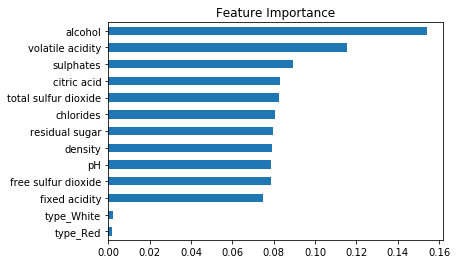

In [17]:
# Plotando o gráfico de feature importance
%matplotlib inline 
feature_importance.sort_values(ascending=True).plot(kind='barh', title='Feature Importance')